## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.emulator import gp_emulator
from cup1d.data import data_MPGADGET
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(sim_label=test_sim_label,
                                zmax=z_max,
                                polyfit=(emu_type=="polyfit"))

In [4]:
# option to add extra P1D (high-resolution)
if True:
    extra_data=data_MPGADGET.P1D_MPGADGET(sim_label=test_sim_label,
                                zmax=z_max,
                                polyfit=(emu_type=="polyfit"),
                                data_cov_label='Karacayli2022')
else:
    extra_data=None

Nz = 15 , Nk = 21


### Emulator and training set

Create a set of training data to train an emulator

In [5]:
if drop_sim_number:
    raise ValueError("update notebook for leave-one-out")
# specify simulation suite and P1D mesurements
archive=gadget_archive.GadgetArchive(postproc='Pedersen21')

In [6]:
emu_params=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu=gp_emulator.GPEmulator(archive=archive,emu_params=emu_params,
                                emu_type=emu_type,kmax_Mpc=kmax_Mpc)

Use custom archive provided by the user
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 1.71 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
#free_param_names=["As","ns","ln_tau_0"]
free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1"]

In [8]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

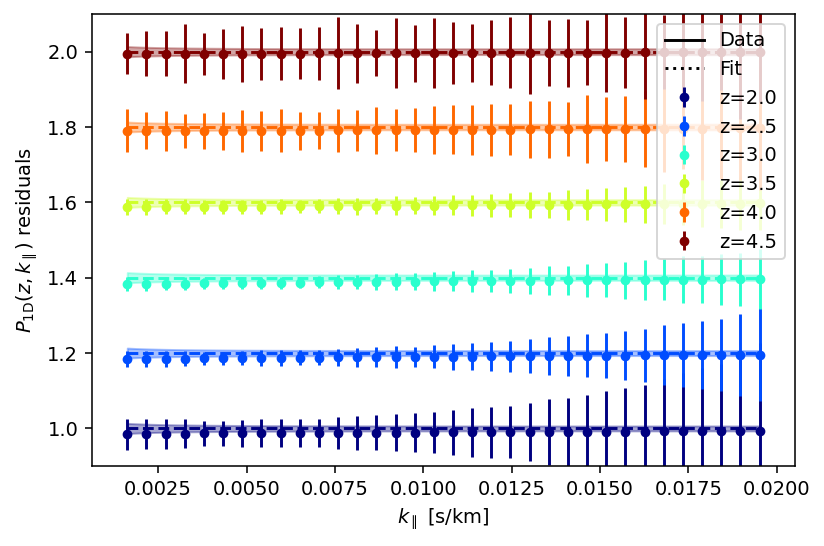

In [9]:
like.plot_p1d(residuals=True,plot_every_iz=2)

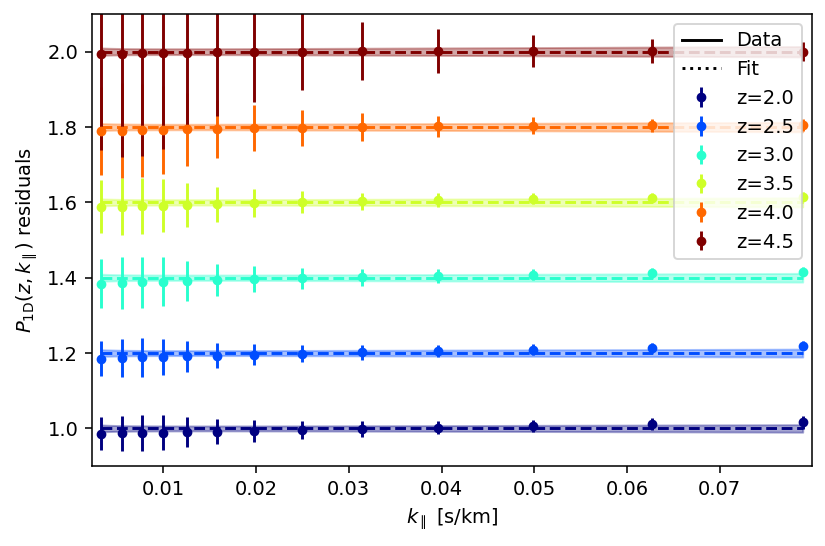

In [10]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [12]:
minimizer.minimize(compute_hesse=True)

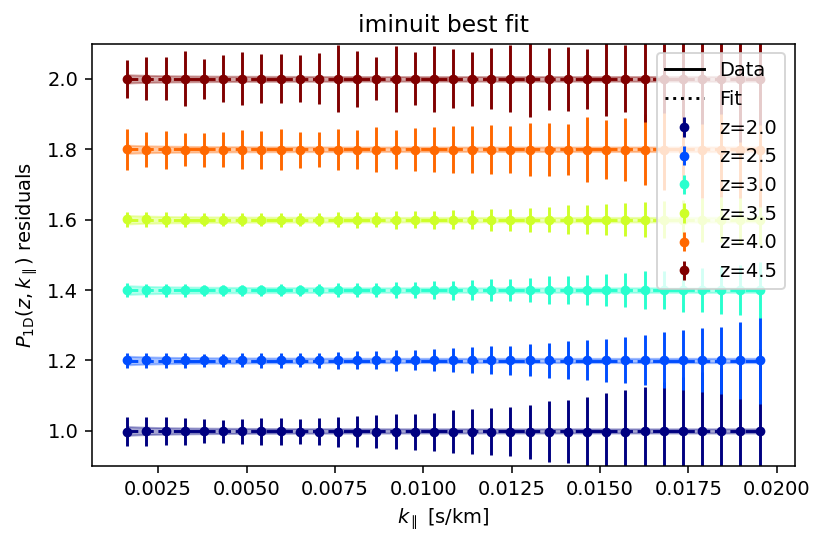

In [13]:
minimizer.plot_best_fit(plot_every_iz=2)

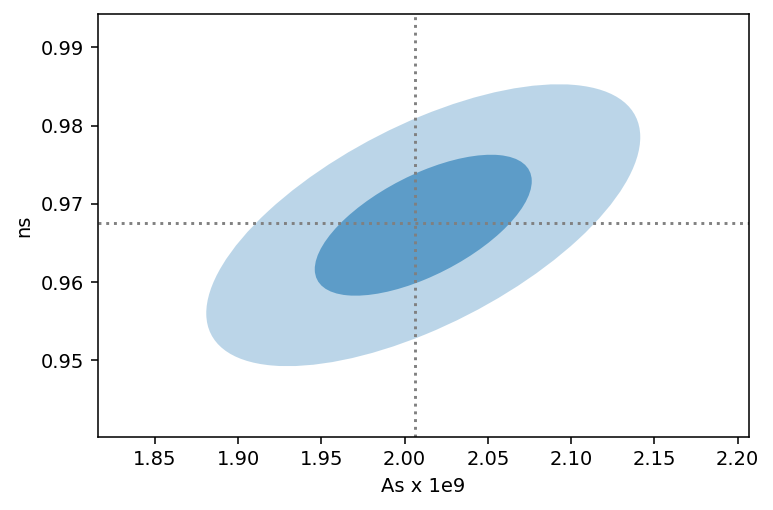

In [14]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [15]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.6                       │              Nfcn = 403              │
│ EDM = 8.3e-12 (Goal: 0.0001)     │           time = 102.5 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.46    │   0.03    │            │            │         │         │       │
│ 1 │ x1   │   0.51    │   0.05    │            │            │         │         │       │
│ 2 │ x2   │   0.51    │   0.08    │            │            │         │         │       │
│ 3 │ x3   │   0.48    │   0.07    │            │            │         │         │       │
│ 4 │ x4   │   0.492   │   0.009   │            │            │         │         │       │
│ 5 │ x5   │   0.51    │   0.05    │            │            │         │         │       │
│ 6 │ x6   │   0.49    │   0.06    │            │            │         │         │       │
│ 7 │ x7   │   0.47    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────┤
│ x0 │  0.000876  0.000978  -0.00221  0.000767  6.99e-05 -0.000786  -0.00115  0.000583 │
│ x1 │  0.000978   0.00281  -0.00335 -0.000477  0.000116 -0.000469  -0.00151  0.000376 │
│ x2 │  -0.00221  -0.00335   0.00692  -0.00248 -0.000423   0.00257   0.00413  -0.00165 │
│ x3 │  0.000767 -0.000477  -0.00248   0.00448  0.000369  -0.00227  -0.00235   0.00196 │
│ x4 │  6.99e-05  0.000116 -0.000423  0.000369  8.02e-05 -0.000259 -0.000409  0.000123 │
│ x5 │ -0.000786 -0.000469   0.00257  -0.00227 -0.000259    0.0022   0.00196  -0.00151 │
│ x6 │  -0.00115  -0.00151   0.00413  -0.00235 -0.000409   0.00196   0.00304 -0.000975 │
│ x7 │  0.000583  0.000376  -0.00165   0.00196  0.000123  -0.00151 -0.000975    0.0019 │
└────┴─────────────────────────────────────────────────────────────────────────────────┘

In [16]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [17]:
#minimizer.minimizer.draw_mnprofile("x0")